In [5]:
import sqlite3
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import MathsUtilities as MUte
import matplotlib.patheffects as path_effects
import GraphHelpers as GH
import matplotlib.lines as mlines
import seaborn as sns
from numpy  import array
%matplotlib inline

#Extend screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
con = sqlite3.connect(r'C:\Users\uqjojeda\Dropbox\APSIMPotato\PotatoMod.db')

In [7]:
Simulations = pd.read_sql("Select * from _Simulations",con)
Simulations.set_index('ID',inplace=True)

In [8]:
Factors = pd.read_sql("Select * from _Factors",con)
Factors.set_index('SimulationID',inplace=True)

In [9]:
LocList = pd.read_excel(r'C:\Users\uqjojeda\Dropbox\APSIMPotato\List of locations.xlsx')
LocList.set_index('metfile',inplace=True)

In [10]:
import re
def extractLocation(lcn):
    lcn = lcn.replace('MET files\\','')
    lcn = re.sub('\d','',lcn)
    lcn = lcn.replace('.met','')
    return lcn
def extractfileName(fn):
    fn = fn.replace('MET files\\','')
    fn = fn.replace('.met','')
    return fn

In [11]:
Obs = pd.read_excel(r'C:\Users\uqjojeda\Dropbox\APSIMPotato\Observed.xlsx')

In [12]:
InitialReport = pd.read_sql("Select * from InitialReport",con)
InitialReport.loc[:,'SimulationName'] = [Simulations.loc[InitialReport.loc[x,'SimulationID'],'Name'] for x in InitialReport.index]
InitialReport.drop(['CheckpointID','Zone','Nitrogen','01','1','Field_','_','Water','Radiation','PlantDensity'],axis=1,inplace=True)
InitialReport.set_index('SimulationID',inplace=True)
InitialReport.loc[:,'Location'] = [extractLocation(x) for x in InitialReport.loc[:,'Weather.FileName']]
InitialReport.loc[:,'FileName'] = [extractfileName(InitialReport.loc[x,'Weather.FileName']) for x in InitialReport.index]
InitialReport.loc[:,'Country'] = [LocList.loc[x,'country'] for x in InitialReport.loc[:,'FileName']]
InitialReport.loc[:,'Loc'] = [LocList.loc[x,'loc'] for x in InitialReport.loc[:,'FileName']]
InitialReport.loc[:,'Country Loc'] = [InitialReport.loc[x,'Country'] + ' ' + InitialReport.loc[x,'Loc'] for x in InitialReport.index] 

In [13]:
DailyReport = pd.read_sql("Select * from DailyReport",con)
DailyReport.loc[:,'SimulationName'] = [Simulations.loc[DailyReport.loc[x,'SimulationID'],'Name'] for x in DailyReport.index]
DailyReport.drop(['CheckpointID','Zone','Nitrogen','01','1','Field_','_','Water','Radiation','PlantDensity'],axis=1,inplace=True)
DailyReport.set_index('SimulationID',inplace=True)

In [14]:
DailyPreObs = pd.read_sql("Select * from TimeSeriesData",con)
DailyPreObs.loc[:,'SimulationName'] = [Simulations.loc[DailyPreObs.loc[x,'SimulationID'],'Name'] for x in DailyPreObs.index]
DailyPreObs.set_index('SimulationID',inplace=True)
DailyPreObs.drop_duplicates(inplace=True)

In [15]:
HarvestReport = pd.read_sql("Select * from HarvestReport",con)
HarvestReport.loc[:,'SimulationName'] = [Simulations.loc[HarvestReport.loc[x,'SimulationID'],'Name'] for x in HarvestReport.index]
HarvestReport.drop(['CheckpointID','Zone','Nitrogen','01','1','Field_','_','Water','Radiation','PlantDensity'],axis=1,inplace=True)
HarvestReport.loc[:,'PlantPopn'] = 1/((HarvestReport.loc[:,'RowWidth']/1000)* (HarvestReport.loc[:,'InterRowPlantSpace']/1000))
HarvestReport.loc[:,'StemPopn'] = HarvestReport.loc[:,'StemPerTuber'] *  HarvestReport.loc[:,'PlantPopn']
HarvestReport.loc[:,'Location'] = [extractLocation(x) for x in HarvestReport.loc[:,'Weather.FileName']]
HarvestReport.set_index('SimulationID',inplace=True)
HarvestReport.loc[:,'FileName'] = [extractfileName(HarvestReport.loc[x,'Weather.FileName']) for x in HarvestReport.index]
HarvestReport.loc[:,'Country'] = [LocList.loc[x,'country'] for x in HarvestReport.loc[:,'FileName']]
HarvestReport.loc[:,'Loc'] = [LocList.loc[x,'loc'] for x in HarvestReport.loc[:,'FileName']]
HarvestReport.loc[:,'Country Loc'] = [HarvestReport.loc[x,'Country'] + ' ' + HarvestReport.loc[x,'Loc'] for x in HarvestReport.index] 

In [16]:
HarvestPreObs = pd.read_sql("Select * from FinalYieldData",con)
HarvestPreObs.loc[:,'SimulationName'] = [Simulations.loc[HarvestPreObs.loc[x,'SimulationID'],'Name'] for x in HarvestPreObs.index]
HarvestPreObs.set_index('SimulationID',inplace=True)
HarvestPreObs.drop_duplicates(inplace=True)

In [17]:
data = pd.merge(left=HarvestReport, right=DailyPreObs, left_on='SimulationName', right_on='SimulationName')
data.rename(columns={'Observed.Potato.Tuber.LiveFWt':'obsFTuWt','Predicted.Potato.Tuber.LiveFWt':'preFTuWt',
                    'Observed.Potato.Tuber.Live.Wt':'obsTuWt','Predicted.Potato.Tuber.Live.Wt':'preTuWt',
                    'Observed.Potato.TotalLive.Wt':'obsToWt','Predicted.Potato.TotalLive.Wt':'preToWt',
                    'Observed.Potato.Leaf.LAI':'obsLAI','Predicted.Potato.Leaf.LAI':'preLAI',
                    'Observed.Potato.Tuber.Live.N':'obsTuLN','Predicted.Potato.Tuber.Live.N':'preTuLN',
                    'Observed.Potato.TotalLive.N':'obsToLN','Predicted.Potato.TotalLive.N':'preToLN',
                    'Weather.Latitude':'lat'}, inplace=True)

#Remove 0 values from the observed file in Total Wt
c=data[data.obsToWt != 0]

#Remove Hermiston, something wierd is happening here
PreData=c[c.Loc != 'Hermiston']

#Create filters
#Removing outliers for population
df_final0 = PreData[PreData.PlantPopn > 3.875968992248062]
df_final1 = df_final0[df_final0.PlantPopn < 5.555555555555555]

#Removing winter sowing
a=df_final1[df_final1.Experiment != 'CPLM8501INVIERNO']

#Removing high latitudes
b=a[a.lat < 40 ]

#Removing high latitudes
PostData=b[b.Loc != 'La Molina']

#Adding month and day of sowing as columns
PostData['SowDate0']  = pd.to_datetime(PostData['PlantingDate'])
PostData['SowDate'] = PostData['SowDate0'].dt.strftime('%Y-%m-%d')
PostData['month'] = PostData['SowDate'].str[5:7]
PostData['day'] = PostData['SowDate'].str[8:10]
PreData['SowDate0']  = pd.to_datetime(PreData['PlantingDate'])
PreData['SowDate'] = PreData['SowDate0'].dt.strftime('%Y-%m-%d')
PreData['month'] = PreData['SowDate'].str[5:7]
PreData['day'] = PreData['SowDate'].str[8:10]

<ipython-input-17-5cd489bf461c>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PostData['SowDate0']  = pd.to_datetime(PostData['PlantingDate'])
<ipython-input-17-5cd489bf461c>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PostData['SowDate'] = PostData['SowDate0'].dt.strftime('%Y-%m-%d')
<ipython-input-17-5cd489bf461c>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [18]:
data.InterRowPlantSpace.quantile(0.9)

333.0

In [19]:
list(PreData.columns)

['Experiment',
 'FolderName',
 'Cultivar',
 'Clock.Today_x',
 'Potato.AboveGround.N',
 'Potato.BelowGround.N',
 'Potato.AboveGround.Wt',
 'Potato.BelowGround.Wt',
 'Potato.Root.Live.Wt',
 'Potato.Root.Live.N',
 'Potato.Root.Live.NConc',
 'Potato.Stem.Live.N',
 'Potato.Stem.Live.NConc',
 'Potato.Stem.Live.Wt',
 'Potato.Leaf.Live.N',
 'Potato.Leaf.Live.NConc',
 'Potato.Leaf.Live.Wt',
 'Potato.Total.N',
 'Potato.Total.Wt',
 'Potato.TotalLive.N',
 'Potato.TotalLive.Wt',
 'Potato.Tuber.LiveFWt.DryMatterContent.Value()',
 'Potato.Tuber.Live.N',
 'Potato.Tuber.Live.NConc',
 'Potato.Tuber.Live.Wt',
 'Potato.Tuber.LiveFWt',
 'Potato.Phenology.EmergenceDAP.Value()',
 'Potato.Phenology.TuberInitiationDAP.Value()',
 'PlantandHarvest.Script.FinalTag',
 'PlantingDate',
 'HarvestDate',
 'PlantingDepth',
 'InterRowPlantSpace',
 'RowWidth',
 'setFinalLeafNumber',
 'StemPerTuber',
 'IrrigApplied',
 'NFertApplied',
 'CumRain',
 'CumEo',
 'lat',
 'Weather.Longitude',
 'Weather.FileName',
 'Weather.CO2',
 

In [20]:
d=PreData[PreData.obsToWt < 2]
d
#d.to_csv(r'C:\Users\uqjojeda\Dropbox\APSIMPotato\Paper docs\Paper 1\data\df.csv', index=None, mode='a')

,Experiment,FolderName,Cultivar,Clock.Today_x,Potato.AboveGround.N,Potato.BelowGround.N,Potato.AboveGround.Wt,Potato.BelowGround.Wt,Potato.Root.Live.Wt,Potato.Root.Live.N,...,Observed.TotalNH4,Predicted.TotalNH4,Pred-Obs.TotalNH4,Observed.Soil.SoilWater.SW(7),Predicted.Soil.SoilWater.SW(7),Pred-Obs.Soil.SoilWater.SW(7),SowDate0,SowDate,month,day
1850,Glenroy_0607,Australia,RussetBurbank,2007-03-24 12:00:00,2.601119,13.092956,82.785157,737.912377,53.133549,0.531335,...,NaN,46.911092,NaN,NaN,NaN,NaN,2006-10-10 12:00:00,2006-10-10,10,10
1851,Glenroy_0607,Australia,RussetBurbank,2007-03-24 12:00:00,2.601119,13.092956,82.785157,737.912377,53.133549,0.531335,...,NaN,2.215982,NaN,NaN,NaN,NaN,2006-10-10 12:00:00,2006-10-10,10,10
1852,Glenroy_0607,Australia,RussetBurbank,2007-03-24 12:00:00,2.601119,13.092956,82.785157,737.912377,53.133549,0.531335,...,NaN,1.494807,NaN,NaN,NaN,NaN,2006-10-10 12:00:00,2006-10-10,10,10
1853,Glenroy_0607,Australia,RussetBurbank,2007-03-24 12:00:00,2.612510,13.101814,83.128813,738.400505,53.145057,0.531451,...,NaN,122.678555,NaN,NaN,NaN,NaN,2006-10-10 12:00:00,2006-10-10,10,10
1854,Glenroy_0607,Australia,RussetBurbank,2007-03-24 12:00:00,2.612510,13.101814,83.128813,738.400505,53.145057,0.531451,...,NaN,3.255143,NaN,NaN,NaN,NaN,2006-10-10 12:00:00,2006-10-10,10,10
1855,Glenroy_0607,Australia,RussetBurbank,2007-03-24 12:00:00,2.612510,13.101814,83.128813,738.400505,53.145057,0.531451,...,NaN,1.499953,NaN,NaN,NaN,NaN,2006-10-10 12:00:00,2006-10-10,10,10
1856,Glenroy_0607,Australia,RussetBurbank,2007-03-24 12:00:00,2.627224,13.113137,83.553219,739.025958,53.163034,0.531630,...,NaN,205.902978,NaN,NaN,NaN,NaN,2006-10-10 12:00:00,2006-10-10,10,10
1857,Glenroy_0607,Australia,RussetBurbank,2007-03-24 12:00:00,2.627224,13.113137,83.553219,739.025958,53.163034,0.531630,...,NaN,8.826364,NaN,NaN,NaN,NaN,2006-10-10 12:00:00,2006-10-10,10,10
1858,Glenroy_0607,Australia,RussetBurbank,2007-03-24 12:00:00,2.627224,13.113137,83.553219,739.025958,53.163034,0.531630,...,NaN,1.501712,NaN,NaN,NaN,NaN,2006-10-10 12:00:00,2006-10-10,10,10
1859,Glenroy_0607,Australia,RussetBurbank,2007-03-24 12:00:00,2.638171,13.125410,83.882266,739.699264,53.172435,0.531724,...,NaN,379.734859,NaN,NaN,NaN,NaN,2006-10-10 12:00:00,2006-10-10,10,10


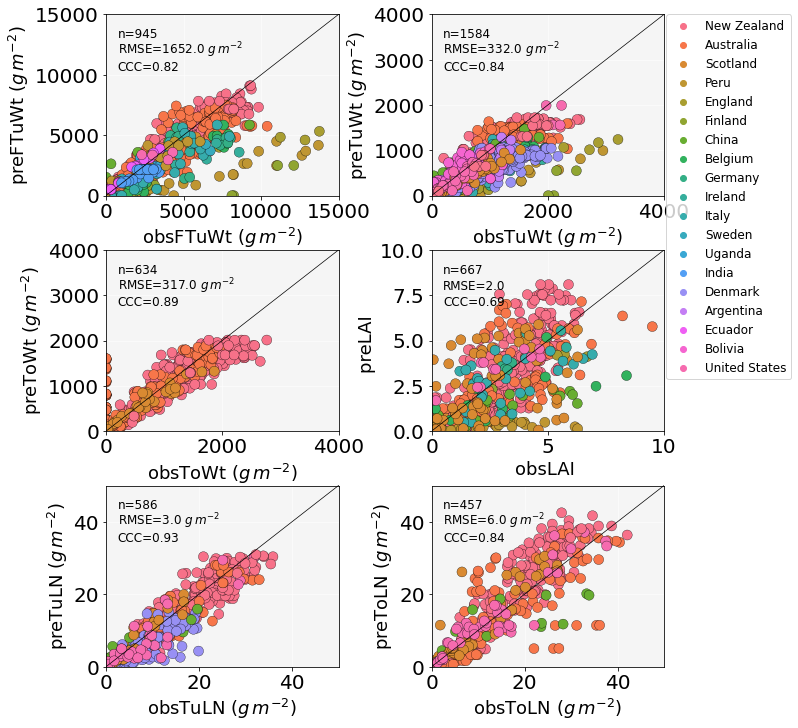

In [21]:
kwargs  =   {'edgecolor':"k"}

fig = plt.figure(figsize=(10,12))

ax=plt.subplot(3, 2, 1)

#ax.set_title('15km x 15km',fontsize= 25,weight='bold') 
#ax.title.set_position([0.5,1.01])
xmax=15000
ymax=15000
sns.scatterplot(x='obsFTuWt', y='preFTuWt', hue='Country',
                alpha=1, data=PreData,linewidth=0.3,**kwargs, s=100)
plt.plot([0,xmax],[0,ymax],"-",color="k", linewidth=0.7)
plt.legend(prop=dict(size=15),bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

# Formatting graph and background
plt.ylabel('preFTuWt ($g\,m^{-2}$)', fontsize =18)
plt.xlabel('obsFTuWt ($g\,m^{-2}$)', fontsize =18)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
#ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0,xmax])
ax.set_ylim([0,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)

#Taking data from dataframe to a list

df_finalSt = PreData[PreData['obsFTuWt'].notna()]

Obs = pd.Series(df_finalSt.obsFTuWt.values)
y_o= Obs.tolist()
Pre = pd.Series(df_finalSt.preFTuWt.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=0)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values
plt.text(xmax*0.05, ymax*0.87,'n='+N,fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.78,'RMSE='+RMSE+' $g\,m^{-2}$',fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.69,'CCC='+CCC,fontsize=12,color='k')
ax.get_legend().remove()

ax=plt.subplot(3, 2, 2)

#ax.set_title('15km x 15km',fontsize= 25,weight='bold') 
#ax.title.set_position([0.5,1.01])
xmax=4000
ymax=4000
sns.scatterplot(x='obsTuWt', y='preTuWt', hue='Country',
                alpha=1, data=PreData,linewidth=0.3,**kwargs, s=100)
plt.plot([0,xmax],[0,ymax],"-",color="k", linewidth=0.7)
plt.legend(prop=dict(size=12),bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

# Formatting graph and background
plt.ylabel('preTuWt ($g\,m^{-2}$)', fontsize =18)
plt.xlabel('obsTuWt ($g\,m^{-2}$)', fontsize =18)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
#ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0,xmax])
ax.set_ylim([0,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)

#Taking data from dataframe to a list

df_finalSt = PreData[PreData['obsTuWt'].notna()]

Obs = pd.Series(df_finalSt.obsTuWt.values)
y_o= Obs.tolist()
Pre = pd.Series(df_finalSt.preTuWt.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=0)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values
plt.text(xmax*0.05, ymax*0.87,'n='+N,fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.78,'RMSE='+RMSE+' $g\,m^{-2}$',fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.69,'CCC='+CCC,fontsize=12,color='k')


ax=plt.subplot(3, 2, 3)

#ax.set_title('15km x 15km',fontsize= 25,weight='bold') 
#ax.title.set_position([0.5,1.01])
xmax=4000
ymax=4000
sns.scatterplot(x='obsToWt', y='preToWt', hue='Country',
                alpha=1, data=PreData,linewidth=0.3,**kwargs, s=100)
plt.plot([0,xmax],[0,ymax],"-",color="k", linewidth=0.7)
plt.legend(prop=dict(size=15),bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

# Formatting graph and background
plt.ylabel('preToWt ($g\,m^{-2}$)', fontsize =18)
plt.xlabel('obsToWt ($g\,m^{-2}$)', fontsize =18)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
#ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0,xmax])
ax.set_ylim([0,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)

#Taking data from dataframe to a list

df_finalSt = PreData[PreData['obsToWt'].notna()]

Obs = pd.Series(df_finalSt.obsToWt.values)
y_o= Obs.tolist()
Pre = pd.Series(df_finalSt.preToWt.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=0)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values
plt.text(xmax*0.05, ymax*0.87,'n='+N,fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.78,'RMSE='+RMSE+' $g\,m^{-2}$',fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.69,'CCC='+CCC,fontsize=12,color='k')
ax.get_legend().remove()

ax=plt.subplot(3, 2, 4)

#ax.set_title('15km x 15km',fontsize= 25,weight='bold') 
#ax.title.set_position([0.5,1.01])
xmax=10
ymax=10
sns.scatterplot(x='obsLAI', y='preLAI', hue='Country',
                alpha=1, data=PreData,linewidth=0.3,**kwargs, s=100)
plt.plot([0,xmax],[0,ymax],"-",color="k", linewidth=0.7)
plt.legend(prop=dict(size=15),bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

# Formatting graph and background
plt.ylabel('preLAI ', fontsize =18)
plt.xlabel('obsLAI ', fontsize =18)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
#ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0,xmax])
ax.set_ylim([0,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)

#Taking data from dataframe to a list

df_finalSt = PreData[PreData['obsLAI'].notna()]

Obs = pd.Series(df_finalSt.obsLAI.values)
y_o= Obs.tolist()
Pre = pd.Series(df_finalSt.preLAI.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=0)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values
plt.text(xmax*0.05, ymax*0.87,'n='+N,fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.78,'RMSE='+RMSE,fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.69,'CCC='+CCC,fontsize=12,color='k')
ax.get_legend().remove()

ax=plt.subplot(3, 2, 5)

#ax.set_title('15km x 15km',fontsize= 25,weight='bold') 
#ax.title.set_position([0.5,1.01])
xmax=50
ymax=50
sns.scatterplot(x='obsTuLN', y='preTuLN', hue='Country',
                alpha=1, data=PreData,linewidth=0.3,**kwargs, s=100)
plt.plot([0,xmax],[0,ymax],"-",color="k", linewidth=0.7)
plt.legend(prop=dict(size=15),bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

# Formatting graph and background
plt.ylabel('preTuLN ($g\,m^{-2}$)', fontsize =18)
plt.xlabel('obsTuLN ($g\,m^{-2}$)', fontsize =18)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
#ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0,xmax])
ax.set_ylim([0,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)

#Taking data from dataframe to a list

df_finalSt = PreData[PreData['obsTuLN'].notna()]

Obs = pd.Series(df_finalSt.obsTuLN.values)
y_o= Obs.tolist()
Pre = pd.Series(df_finalSt.preTuLN.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=0)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values
plt.text(xmax*0.05, ymax*0.87,'n='+N,fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.78,'RMSE='+RMSE+' $g\,m^{-2}$',fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.69,'CCC='+CCC,fontsize=12,color='k')
ax.get_legend().remove()

ax=plt.subplot(3, 2, 6)

#ax.set_title('15km x 15km',fontsize= 25,weight='bold') 
#ax.title.set_position([0.5,1.01])
xmax=50
ymax=50
sns.scatterplot(x='obsToLN', y='preToLN', hue='Country',
                alpha=1, data=PreData,linewidth=0.3,**kwargs, s=100)
plt.plot([0,xmax],[0,ymax],"-",color="k", linewidth=0.7)
plt.legend(prop=dict(size=15),bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

# Formatting graph and background
plt.ylabel('preToLN ($g\,m^{-2}$)', fontsize =18)
plt.xlabel('obsToLN ($g\,m^{-2}$)', fontsize =18)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
#ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0,xmax])
ax.set_ylim([0,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)

#Taking data from dataframe to a list

df_finalSt = PreData[PreData['obsToLN'].notna()]

Obs = pd.Series(df_finalSt.obsToLN.values)
y_o= Obs.tolist()
Pre = pd.Series(df_finalSt.preToLN.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=0)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values
plt.text(xmax*0.05, ymax*0.87,'n='+N,fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.78,'RMSE='+RMSE+' $g\,m^{-2}$',fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.69,'CCC='+CCC,fontsize=12,color='k')
ax.get_legend().remove()

plt.subplots_adjust(wspace=0.4, hspace=0.3)
#plt.savefig(r'C:\Users\uqjojeda\Dropbox\APSIMPotato\Paper docs\Paper 1\data\PreDataSowDate.png', dpi=300,bbox_inches='tight')

ValueError: Could not interpret value `Weather.Latitude` for parameter `hue`

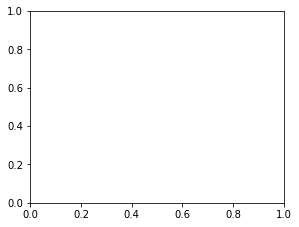

In [22]:
kwargs  =   {'edgecolor':"k"}

fig = plt.figure(figsize=(10,12))

ax=plt.subplot(3, 2, 1)

#ax.set_title('15km x 15km',fontsize= 25,weight='bold') 
#ax.title.set_position([0.5,1.01])
xmax=15000
ymax=15000
sns.scatterplot(x='obsFTuWt', y='preFTuWt', hue='Weather.Latitude',
                alpha=1, data=PostData,linewidth=0.3,**kwargs, s=100)
plt.plot([0,xmax],[0,ymax],"-",color="k", linewidth=0.7)
plt.legend(prop=dict(size=15),bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

# Formatting graph and background
plt.ylabel('preFTuWt ($g\,m^{-2}$)', fontsize =18)
plt.xlabel('obsFTuWt ($g\,m^{-2}$)', fontsize =18)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
#ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0,xmax])
ax.set_ylim([0,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)

#Taking data from dataframe to a list

df_finalSt = PostData[PostData['obsFTuWt'].notna()]

Obs = pd.Series(df_finalSt.obsFTuWt.values)
y_o= Obs.tolist()
Pre = pd.Series(df_finalSt.preFTuWt.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=0)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values
plt.text(xmax*0.05, ymax*0.87,'n='+N,fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.78,'RMSE='+RMSE+' $g\,m^{-2}$',fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.69,'CCC='+CCC,fontsize=12,color='k')
ax.get_legend().remove()

ax=plt.subplot(3, 2, 2)

#ax.set_title('15km x 15km',fontsize= 25,weight='bold') 
#ax.title.set_position([0.5,1.01])
xmax=4000
ymax=4000
sns.scatterplot(x='obsTuWt', y='preTuWt', hue='Weather.Latitude',
                alpha=1, data=PostData,linewidth=0.3,**kwargs, s=100)
plt.plot([0,xmax],[0,ymax],"-",color="k", linewidth=0.7)
plt.legend(prop=dict(size=12),bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

# Formatting graph and background
plt.ylabel('preTuWt ($g\,m^{-2}$)', fontsize =18)
plt.xlabel('obsTuWt ($g\,m^{-2}$)', fontsize =18)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
#ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0,xmax])
ax.set_ylim([0,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)

#Taking data from dataframe to a list

df_finalSt = PostData[PostData['obsTuWt'].notna()]

Obs = pd.Series(df_finalSt.obsTuWt.values)
y_o= Obs.tolist()
Pre = pd.Series(df_finalSt.preTuWt.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=0)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values
plt.text(xmax*0.05, ymax*0.87,'n='+N,fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.78,'RMSE='+RMSE+' $g\,m^{-2}$',fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.69,'CCC='+CCC,fontsize=12,color='k')


ax=plt.subplot(3, 2, 3)

#ax.set_title('15km x 15km',fontsize= 25,weight='bold') 
#ax.title.set_position([0.5,1.01])
xmax=4000
ymax=4000
sns.scatterplot(x='obsToWt', y='preToWt', hue='Weather.Latitude',
                alpha=1, data=PostData,linewidth=0.3,**kwargs, s=100)
plt.plot([0,xmax],[0,ymax],"-",color="k", linewidth=0.7)
plt.legend(prop=dict(size=15),bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

# Formatting graph and background
plt.ylabel('preToWt ($g\,m^{-2}$)', fontsize =18)
plt.xlabel('obsToWt ($g\,m^{-2}$)', fontsize =18)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
#ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0,xmax])
ax.set_ylim([0,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)

#Taking data from dataframe to a list

df_finalSt = PostData[PostData['obsToWt'].notna()]

Obs = pd.Series(df_finalSt.obsToWt.values)
y_o= Obs.tolist()
Pre = pd.Series(df_finalSt.preToWt.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=0)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values
plt.text(xmax*0.05, ymax*0.87,'n='+N,fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.78,'RMSE='+RMSE+' $g\,m^{-2}$',fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.69,'CCC='+CCC,fontsize=12,color='k')
ax.get_legend().remove()

ax=plt.subplot(3, 2, 5)

#ax.set_title('15km x 15km',fontsize= 25,weight='bold') 
#ax.title.set_position([0.5,1.01])
xmax=50
ymax=50
sns.scatterplot(x='obsTuLN', y='preTuLN', hue='Weather.Latitude',
                alpha=1, data=PostData,linewidth=0.3,**kwargs, s=100)
plt.plot([0,xmax],[0,ymax],"-",color="k", linewidth=0.7)
plt.legend(prop=dict(size=15),bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

# Formatting graph and background
plt.ylabel('preTuLN ($g\,m^{-2}$)', fontsize =18)
plt.xlabel('obsTuLN ($g\,m^{-2}$)', fontsize =18)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
#ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0,xmax])
ax.set_ylim([0,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)

#Taking data from dataframe to a list

df_finalSt = PostData[PostData['obsTuLN'].notna()]

Obs = pd.Series(df_finalSt.obsTuLN.values)
y_o= Obs.tolist()
Pre = pd.Series(df_finalSt.preTuLN.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=0)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values
plt.text(xmax*0.05, ymax*0.87,'n='+N,fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.78,'RMSE='+RMSE+' $g\,m^{-2}$',fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.69,'CCC='+CCC,fontsize=12,color='k')
ax.get_legend().remove()

ax=plt.subplot(3, 2, 6)

#ax.set_title('15km x 15km',fontsize= 25,weight='bold') 
#ax.title.set_position([0.5,1.01])
xmax=50
ymax=50
sns.scatterplot(x='obsToLN', y='preToLN', hue='Weather.Latitude',
                alpha=1, data=PostData,linewidth=0.3,**kwargs, s=100)
plt.plot([0,xmax],[0,ymax],"-",color="k", linewidth=0.7)
plt.legend(prop=dict(size=15),bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

# Formatting graph and background
plt.ylabel('preToLN ($g\,m^{-2}$)', fontsize =18)
plt.xlabel('obsToLN ($g\,m^{-2}$)', fontsize =18)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
#ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0,xmax])
ax.set_ylim([0,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)

#Taking data from dataframe to a list

df_finalSt = PostData[PostData['obsToLN'].notna()]

Obs = pd.Series(df_finalSt.obsToLN.values)
y_o= Obs.tolist()
Pre = pd.Series(df_finalSt.preToLN.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=0)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values
plt.text(xmax*0.05, ymax*0.87,'n='+N,fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.78,'RMSE='+RMSE+' $g\,m^{-2}$',fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.69,'CCC='+CCC,fontsize=12,color='k')
ax.get_legend().remove()

plt.subplots_adjust(wspace=0.4, hspace=0.3)
#plt.savefig(r'C:\Users\uqjojeda\Dropbox\APSIMPotato\Paper docs\Paper 1\data\PostHarvest.png', dpi=300,bbox_inches='tight')